In [ ]:
# !git clone https://github.com/Kaz0818/vision_utils.git

Cloning into 'vision_utils'...
remote: Enumerating objects: 329, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 329 (delta 23), reused 41 (delta 13), pack-reused 260 (from 1)
Receiving objects: 100% (329/329), 243.44 KiB | 1.04 MiB/s, done.
Resolving deltas: 100% (133/133), done.


In [20]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision import transforms
import timm
import wandb
from vision_utils.trainers.train import Trainer
from vision_utils.plotting import  Visualizer
from vision_utils.grad_cam import GradCAMVisualizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### データ準備

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

In [12]:
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform) 
val_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform) 
random_idx = np.random.randint(0, len(train_dataset), 100)
random_idx_val = np.random.randint(0, len(val_dataset), 10)
sub_train_data = Subset(train_dataset, random_idx)
sub_val_data = Subset(val_dataset, random_idx_val)
train_loader = DataLoader(sub_train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(sub_val_data, batch_size=16,shuffle=False)

In [13]:
config = dict(
    epochs=2,
    classes=len(train_dataset.classes),
    batch_size=16,
    learning_rate=0.001,
    dataset="CIFAR10_test",
    arch="efficientnet_b0.ra_in1k",
    optimizer="Adam")
CLASSES = train_dataset.classes
# CHECKPOINT_DIR = "checkpoints" # チェックポイントの保存先

Epoch 1/2 | Train Loss: 2.7663, Acc: 0.2500 | Val Loss: 3.2921, Acc: 0.2000

[INFO] Checkpoint saved: /Users/kaz0818/developer/learning/sandbox_wandb/wandb/run-20250910_073925-03dfovn0/files/checkpoints/efficientnet_b0.ra_in1k/best_model.pth (Val Loss: 3.2921)


Epoch 2/2 | Train Loss: 0.2191, Acc: 0.9600 | Val Loss: 4.4577, Acc: 0.1000

[INFO] Training finished.
[INFO] Uploaded best model to W&B: best_model.pth
[INFO] TensorBoard writer closed.
[Visualizer] Artifacts will be saved to: /Users/kaz0818/developer/learning/sandbox_wandb/wandb/run-20250910_073925-03dfovn0/files/results

--- [Visualizer] Starting Final Evaluation ---
[Visualizer] Loaded model checkpoint from: /Users/kaz0818/developer/learning/sandbox_wandb/wandb/run-20250910_073925-03dfovn0/files/checkpoints/efficientnet_b0.ra_in1k/best_model.pth


[Visualizer] Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


[Visualizer] Logged confusion matrix to W&B.

Classification Report:
              precision    recall  f1-score   support

    airplane     0.0000    0.0000    0.0000         0
  automobile     0.0000    0.0000    0.0000         1
        bird     0.0000    0.0000    0.0000         0
         cat     0.0000    0.0000    0.0000         1
        deer     0.4000    1.0000    0.5714         2
         dog     0.0000    0.0000    0.0000         1
        frog     0.0000    0.0000    0.0000         2
       horse     0.0000    0.0000    0.0000         0
        ship     0.0000    0.0000    0.0000         2
       truck     0.0000    0.0000    0.0000         1

    accuracy                         0.2000        10
   macro avg     0.0400    0.1000    0.0571        10
weighted avg     0.0800    0.2000    0.1143        10

[Visualizer] Logged classification report to W&B.
🚀 [Visualizer] Evaluation and plotting complete.
[GradCAMVisualizer] Artifacts will be saved to: /Users/kaz0818/developer/

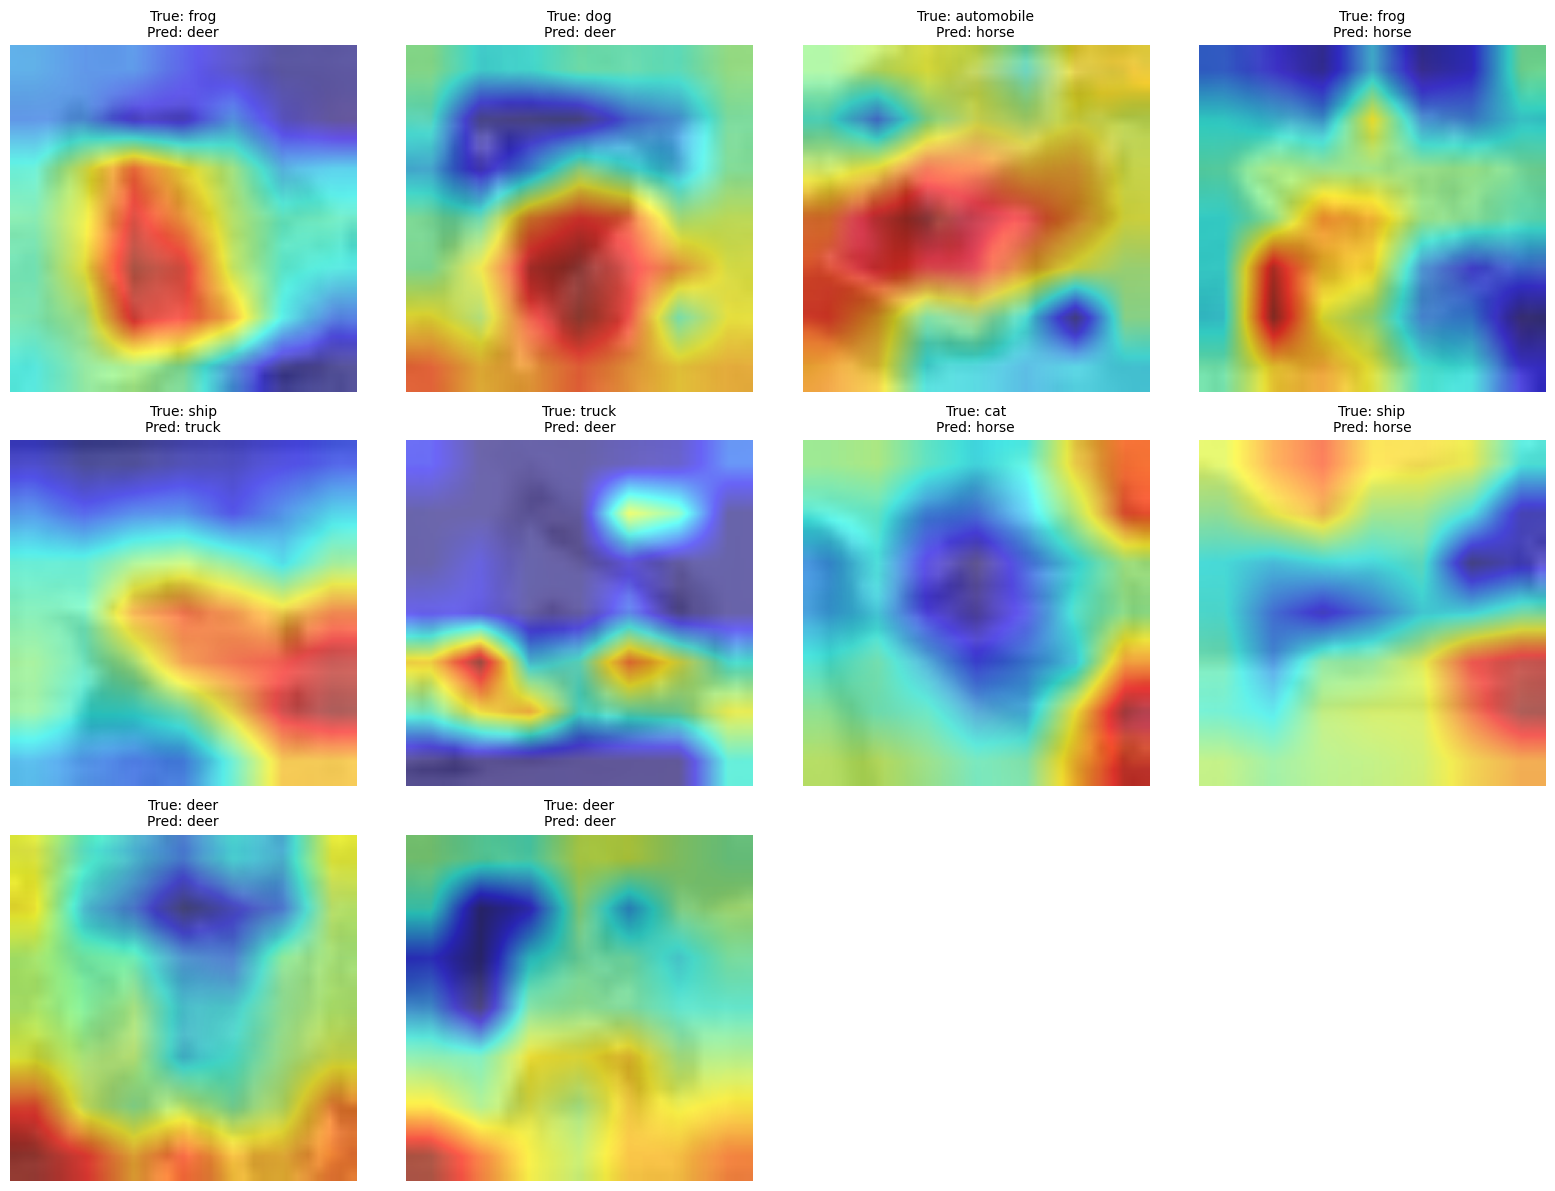

誤分類した画像を最大16枚探し、Grad-CAMを可視化します...
グリッド画像を保存しました: /Users/kaz0818/developer/learning/sandbox_wandb/wandb/run-20250910_073925-03dfovn0/files/results/miscls/miscls_grid.jpg


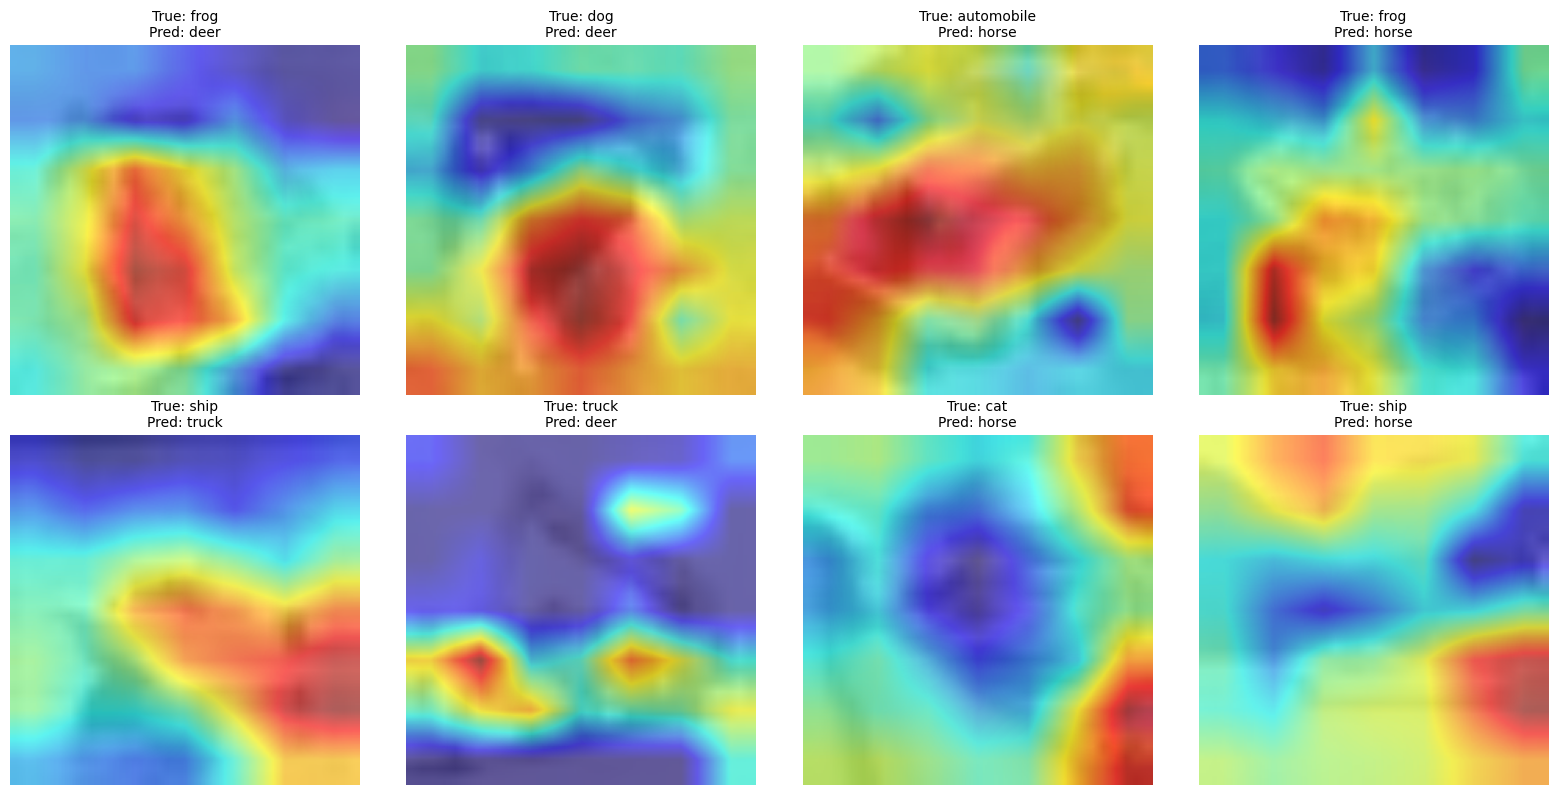

epoch,▁█
train/acc,▁█
train/loss,█▁
val/acc,█▁
val/loss,▁█
epoch,1
train/acc,0.96
train/loss,0.21907
val/acc,0.1
val/loss,4.45769



✅ Script finished. Check your W&B dashboard.


In [21]:
# 2. W&Bのrunを開始
with wandb.init(project="cifar10_test", name=f"{config['arch']}_timm_last", config=config) as run:
    
    # 3. 共通のリソースを準備
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    arch = run.config.get("arch", "efficientnet_b0.ra_in1k")
    model = timm.create_model(arch , pretrained=True, num_classes=len(CLASSES))
    CHECKPOINT_DIR = Path(run.dir) / "checkpoints" / arch
    CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
    
    train_loader
    val_loader
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

    # 4. Trainerを初期化し、学習を実行
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=run.config.epochs,
        config=run.config,
        device=device,
        checkpoint_dir=CHECKPOINT_DIR,
        wandb_run=run 
    )
    trainer.train()

    # 5. 学習から最高のモデルのパスを取得
    best_model_path = trainer.get_best_model_path()

    # 6. Visualizerを初期化し、評価とプロットを実行
    if best_model_path:
        
    # （任意）main側の事前照合。Visualizer/GradCAMに実装済みなら省略可
        try:
            ckpt = torch.load(best_model_path, map_location="cpu")
            ckpt_arch = str(ckpt.get("arch", "unknown"))
            if ckpt_arch != "unknown" and ckpt_arch != arch:
                raise ValueError(f"Checkpoint arch mismatch: ckpt={ckpt_arch}, current={arch}")
        except Exception as e:
            print(f"[Main] Skip evaluation due to checkpoint mismatch: {e}")
        else:
            visualizer = Visualizer(wandb_run=run)
            visualizer.run_evaluation(
                model=model,
                model_path=best_model_path,
                dataloader=val_loader,
                class_names=CLASSES,
                device=device
            )

            grad_cam = GradCAMVisualizer(
                wandb_run=run,
                model_path=best_model_path,
                model=model,
                class_names=CLASSES,
                device=device
            )
            grad_cam.plot_random_samples(val_loader)
            grad_cam.plot_misclassified_samples(val_loader)
    else:
        print("[Main] No best model found. Skipping evaluation.")

# withブロックを抜けると、runが正常に終了します
print("\n✅ Script finished. Check your W&B dashboard.")